# Final Experiments - Single-label CNNText Ensemble

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [3]:
print(len(top10s[0]))

1159


In [5]:
print(top5s[0][0])

F. One Occurrence
time limit per test3 seconds
memory limit per test768 megabytes
inputstandard input
outputstandard output
You are given an array a
consisting of n
integers, and q
queries to it. i
-th query is denoted by two integers li
and ri
. For each query, you have to find any integer that occurs exactly once in the subarray of a
from index li
to index ri
(a subarray is a contiguous subsegment of an array). For example, if a=[1,1,2,3,2,4]
, then for query (li=2,ri=6)
the subarray we are interested in is [1,2,3,2,4]
, and possible answers are 1
, 3
and 4
; for query (li=1,ri=2)
the subarray we are interested in is [1,1]
, and there is no such element that occurs exactly once.
Can you answer all of the queries?
Input
The first line contains one integer n
(1≤n≤5⋅105
).
The second line contains n
integers a1,a2,…,an
(1≤ai≤5⋅105
).
The third line contains one integer q
(1≤q≤5⋅105
).
Then q
lines follow, i
-th line containing two integers li
and ri
representing i
-th query (1≤li≤ri≤n
)

## CNN Experiments

In [7]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, class_num, channel_in=1, 
                 kernel_sizes=[3, 4, 5], kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(embed_num, embed_dim)
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
#         self.bn1 = nn.BatchNorm2d(kernel_num)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

In [8]:
class CNN_Ensemble(nn.Module):
    def __init__(self, embed_num, class_num, n=5):
        super().__init__()
        self.class_num = class_num
        self.n = n
        cnns = [CNN_Text(embed_num, class_num) for _ in range(n)]
        self.cnns = nn.ModuleList(cnns)
#         self.softmax = nn.Sofmax()
    
    def forward(self, x):
        outs = torch.cat([cnn(x) for cnn in self.cnns], dim=1)
        outs = outs.view(-1, self.n, self.class_num)        
        out = torch.sum(outs, dim=1)

        return out

### 5-class

In [8]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [9]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Ensemble(in_dim, out_dim),
                               f'{i}_en_cnntext5s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_en_cnntext5s_0 exists.


 19%|█▉        | 3/16 [00:01<00:05,  2.20it/s, loss=0.179]


KeyboardInterrupt: 

In [6]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-ensemble_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-ensemble_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.63      0.89      0.74       550
             dp       0.61      0.51      0.55       550
         greedy       0.56      0.51      0.54       550
 implementation       0.64      0.65      0.65       550
           math       0.64      0.54      0.59       550

    avg / total       0.62      0.62      0.61      2750

0.62
0.6128771523725005
Normalized confusion matrix
[[0.88545 0.04182 0.02727 0.01818 0.02727]
 [0.18    0.50909 0.19091 0.05091 0.06909]
 [0.09818 0.13091 0.50909 0.17091 0.09091]
 [0.10727 0.04    0.08727 0.65273 0.11273]
 [0.13273 0.11636 0.08727 0.12    0.54364]]
0.8854545454545455


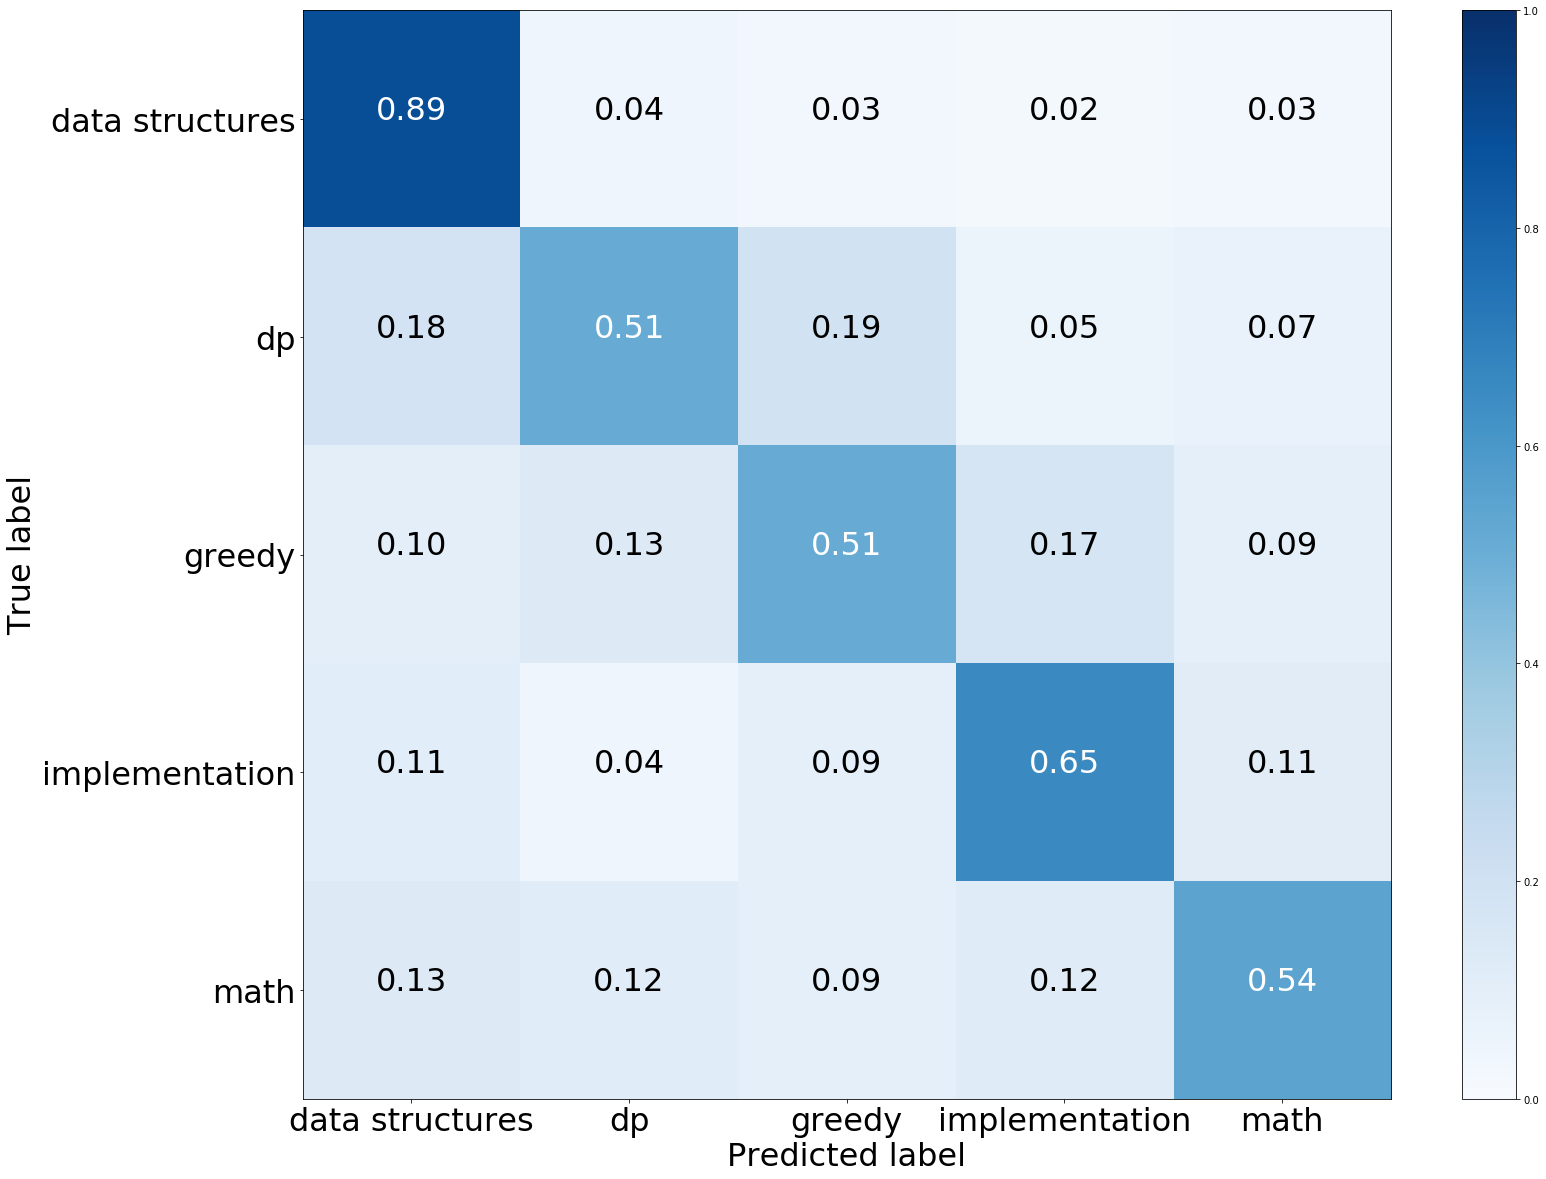

In [7]:
# more recent
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)

### 10-class

In [9]:
trunner = TextRunner([None], top10s[0], top10s[1], 'top10s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [10]:
runs = 5
out_dim = 10

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+41)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Ensemble(in_dim, out_dim),
                           f'{i}_en_cnntext10s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=1,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=1,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_en_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080754   0.073879   0.482759  
    1      0.065721   0.06667    0.508621                   
    2      0.050922   0.066458   0.534483                   
    3      0.036071   0.068409   0.534483                   
    4      0.023645   0.074214   0.474138                   
    5      0.020994   0.084041   0.508621                   
    6      0.043024   0.087409   0.267241                   
    7      0.037018   0.105889   0.491379                   
    8      0.036439   0.070018   0.568966                   
    9      0.0421     0.095015   0.491379                   

0.5689655172413793
Note: Model directory for 0_en_cnntext10s_1 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080729   0.075015   0.465517  
    1      0.06549    0.067777   0.551724                   
    2      0.050208   0.066174   0.577586                   
    3      0.034885   0.067347   0.543103                   
    4      0.021724   0.071445   0.560345                   
    5      0.014286   0.082459   0.387931                   
    6      0.025365   0.119087   0.37069                    
    7      0.039641   0.078263   0.456897                   
    8      0.030839   0.076919   0.551724                   
    9      0.029032   0.089107   0.491379                   

0.5732758620689655
Note: Model directory for 0_en_cnntext10s_2 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080041   0.078765   0.318966  
    1      0.064972   0.072482   0.456897                   
    2      0.050107   0.070818   0.482759                   
    3      0.035327   0.071905   0.448276                   
    4      0.02352    0.073621   0.456897                   
    5      0.02383    0.118883   0.327586                   
    6      0.037331   0.080933   0.448276                   
    7      0.03298    0.089774   0.37069                    
    8      0.027965   0.089669   0.413793                   
    9      0.033277   0.092272   0.491379                   

0.5459770114942529
Note: Model directory for 0_en_cnntext10s_3 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079765   0.074727   0.362069  
    1      0.065205   0.069535   0.508621                   
    2      0.050466   0.070529   0.491379                   
    3      0.035659   0.073592   0.448276                   
    4      0.023367   0.086988   0.284483                   
    5      0.021149   0.078946   0.448276                   
    6      0.030385   0.073231   0.517241                   
    7      0.028483   0.083689   0.387931                   
    8      0.030398   0.094142   0.275862                   
    9      0.032982   0.086472   0.327586                   

0.5387931034482759
Note: Model directory for 0_en_cnntext10s_4 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079315   0.075505   0.362069  
    1      0.064157   0.067734   0.508621                   
    2      0.048981   0.065931   0.543103                   
    3      0.033528   0.066819   0.560345                   
    4      0.02064    0.069212   0.508621                   
    5      0.015734   0.070038   0.568966                   
    6      0.031223   0.071894   0.560345                   
    7      0.034041   0.093663   0.387931                   
    8      0.028951   0.079062   0.413793                   
    9      0.035872   0.087439   0.405172                   

0.5448275862068965
Note: Model directory for 0_en_cnntext10s_5 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079335   0.076448   0.362069  
    1      0.06416    0.070313   0.474138                   
    2      0.049175   0.06889    0.465517                   
    3      0.034042   0.068643   0.474138                   
    4      0.021466   0.070622   0.474138                   
    5      0.017006   0.125909   0.172414                   
    6      0.033724   0.084416   0.405172                   
    7      0.037364   0.082448   0.37931                    
    8      0.028182   0.087503   0.439655                   
    9      0.028215   0.082841   0.448276                   

0.5330459770114943
Note: Model directory for 0_en_cnntext10s_6 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079678   0.069701   0.448276  
    1      0.065071   0.06154    0.517241                   
    2      0.049887   0.061181   0.543103                   
    3      0.034643   0.063835   0.543103                   
    4      0.0224     0.074968   0.508621                   
    5      0.021817   0.087307   0.362069                   
    6      0.034948   0.078355   0.456897                   
    7      0.03304    0.083634   0.456897                   
    8      0.031665   0.075217   0.482759                   
    9      0.037909   0.093974   0.465517                   

0.5344827586206896
Note: Model directory for 0_en_cnntext10s_7 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079226   0.078676   0.318966  
    1      0.065076   0.072929   0.465517                   
    2      0.050532   0.074003   0.491379                   
    3      0.036477   0.077292   0.474138                   
    4      0.027445   0.06948    0.577586                   
    5      0.028646   0.075709   0.465517                   
    6      0.025752   0.08239    0.396552                   
    7      0.03141    0.075178   0.439655                   
    8      0.032659   0.091684   0.344828                   
    9      0.035464   0.11908    0.37069                    

0.5398706896551724
Note: Model directory for 0_en_cnntext10s_8 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.081132   0.06907    0.508621  
    1      0.066233   0.063872   0.62931                    
    2      0.051176   0.06314    0.62931                    
    3      0.036167   0.064935   0.612069                   
    4      0.023687   0.073715   0.568966                   
    5      0.020483   0.083044   0.422414                   
    6      0.032446   0.076305   0.568966                   
    7      0.034109   0.077637   0.448276                   
    8      0.033305   0.097623   0.155172                   
    9      0.034407   0.082064   0.525862                   

0.5498084291187739
Note: Model directory for 0_en_cnntext10s_9 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.081118   0.069167   0.486957  
    1      0.066016   0.063727   0.53913                    
    2      0.051105   0.065059   0.53913                    
    3      0.036207   0.068005   0.556522                   
    4      0.023819   0.074318   0.547826                   
    5      0.021662   0.0875     0.573913                   
    6      0.032509   0.079953   0.521739                   
    7      0.032693   0.097162   0.356522                   
    8      0.030083   0.084829   0.504348                   
    9      0.033781   0.089819   0.504348                   

0.5522001725625539
Note: Model directory for 1_en_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080302   0.073322   0.439655  
    1      0.064961   0.066168   0.560345                   
    2      0.049595   0.065885   0.586207                   
    3      0.034325   0.06772    0.568966                   
    4      0.021674   0.075968   0.534483                   
    5      0.016371   0.12804    0.198276                   
    6      0.032033   0.092416   0.465517                   
    7      0.040159   0.099304   0.189655                   
    8      0.029587   0.087937   0.37931                    
    9      0.031334   0.075401   0.439655                   

0.5552941176470588
Note: Model directory for 1_en_cnntext10s_1 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.07968    0.074569   0.405172  
    1      0.064928   0.068915   0.5                        
    2      0.049851   0.069182   0.525862                   
    3      0.034653   0.071178   0.525862                   
    4      0.02188    0.078017   0.482759                   
    5      0.015957   0.125914   0.224138                   
    6      0.030495   0.08702    0.474138                   
    7      0.030859   0.075691   0.448276                   
    8      0.026441   0.108768   0.301724                   
    9      0.030144   0.088598   0.431034                   

0.5528396836808052
Note: Model directory for 1_en_cnntext10s_2 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079603   0.070728   0.413793  
    1      0.064091   0.065406   0.525862                   
    2      0.048845   0.063168   0.568966                   
    3      0.033535   0.062919   0.534483                   
    4      0.021062   0.064713   0.560345                   
    5      0.019816   0.116838   0.318966                   
    6      0.031518   0.070231   0.551724                   
    7      0.036281   0.077043   0.431034                   
    8      0.030967   0.081788   0.474138                   
    9      0.029859   0.079075   0.508621                   

0.5540809555408096
Note: Model directory for 1_en_cnntext10s_3 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079461   0.072688   0.431034  
    1      0.064042   0.06658    0.517241                   
    2      0.048624   0.066025   0.508621                   
    3      0.033156   0.068173   0.5                        
    4      0.020386   0.072415   0.508621                   
    5      0.017812   0.091972   0.336207                   
    6      0.025732   0.08656    0.37931                    
    7      0.035845   0.073796   0.517241                   
    8      0.033411   0.087204   0.37931                    
    9      0.03109    0.088372   0.456897                   

0.5514479359211337
Note: Model directory for 1_en_cnntext10s_4 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079239   0.078135   0.353448  
    1      0.064188   0.072837   0.474138                   
    2      0.049145   0.073194   0.482759                   
    3      0.034128   0.074408   0.5                        
    4      0.021788   0.081126   0.448276                   
    5      0.018805   0.095466   0.310345                   
    6      0.033432   0.089526   0.37931                    
    7      0.034267   0.098071   0.258621                   
    8      0.030539   0.101367   0.284483                   
    9      0.040214   0.099729   0.396552                   

0.5480161012075906
Note: Model directory for 1_en_cnntext10s_5 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080032   0.071099   0.482759  
    1      0.065673   0.067162   0.551724                   
    2      0.050998   0.066196   0.543103                   
    3      0.036536   0.067043   0.560345                   
    4      0.026121   0.066253   0.586207                   
    5      0.033681   0.07952    0.586207                   
    6      0.038578   0.08692    0.405172                   
    7      0.036463   0.078958   0.508621                   
    8      0.033765   0.087905   0.534483                   
    9      0.035729   0.087638   0.465517                   

0.5504043126684636
Note: Model directory for 1_en_cnntext10s_6 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079879   0.075128   0.37931   
    1      0.064695   0.067363   0.517241                   
    2      0.04955    0.067127   0.508621                   
    3      0.034329   0.069016   0.491379                   
    4      0.021681   0.075246   0.474138                   
    5      0.017415   0.098782   0.293103                   
    6      0.033862   0.083071   0.396552                   
    7      0.035356   0.081416   0.448276                   
    8      0.031429   0.094691   0.422414                   
    9      0.032703   0.085983   0.422414                   

0.5484525621511923
Note: Model directory for 1_en_cnntext10s_7 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080485   0.072681   0.465517  
    1      0.065651   0.069217   0.551724                   
    2      0.050699   0.069134   0.551724                   
    3      0.035698   0.070483   0.551724                   
    4      0.022858   0.077809   0.482759                   
    5      0.016351   0.11076    0.318966                   
    6      0.030831   0.104911   0.482759                   
    7      0.037052   0.071553   0.5                        
    8      0.031468   0.086246   0.362069                   
    9      0.03575    0.113791   0.439655                   

0.5486344034499281
Note: Model directory for 1_en_cnntext10s_8 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.081069   0.071468   0.5       
    1      0.066504   0.06573    0.560345                   
    2      0.052198   0.063673   0.577586                   
    3      0.03788    0.06355    0.594828                   
    4      0.026596   0.063075   0.577586                   
    5      0.028939   0.06909    0.482759                   
    6      0.033676   0.077918   0.448276                   
    7      0.032299   0.075033   0.603448                   
    8      0.036033   0.075755   0.474138                   
    9      0.040911   0.103251   0.5                        

0.5515206536541081
Note: Model directory for 1_en_cnntext10s_9 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079289   0.074977   0.382609  
    1      0.064224   0.067358   0.46087                    
    2      0.049093   0.065706   0.504348                   
    3      0.03372    0.066881   0.521739                   
    4      0.020773   0.068863   0.513043                   
    5      0.015716   0.089183   0.33913                    
    6      0.025858   0.115186   0.408696                   
    7      0.033242   0.07937    0.417391                   
    8      0.031206   0.099224   0.243478                   
    9      0.027204   0.077657   0.504348                   

0.5500431406384815
Note: Model directory for 2_en_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080201   0.070349   0.456897  
    1      0.065728   0.066234   0.568966                   
    2      0.051156   0.066148   0.594828                   
    3      0.036349   0.067661   0.577586                   
    4      0.023643   0.073045   0.568966                   
    5      0.018146   0.078195   0.465517                   
    6      0.032878   0.071711   0.551724                   
    7      0.034808   0.073499   0.465517                   
    8      0.028871   0.118355   0.301724                   
    9      0.032762   0.071765   0.534483                   

0.5521774856203779
Note: Model directory for 2_en_cnntext10s_1 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079996   0.073365   0.37931   
    1      0.065242   0.066352   0.508621                   
    2      0.049934   0.065129   0.551724                   
    3      0.034418   0.065753   0.534483                   
    4      0.021286   0.068704   0.525862                   
    5      0.013281   0.078028   0.422414                   
    6      0.019254   0.114373   0.413793                   
    7      0.036111   0.069102   0.474138                   
    8      0.030764   0.07106    0.525862                   
    9      0.02986    0.100187   0.413793                   

0.552156862745098
Note: Model directory for 2_en_cnntext10s_2 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080434   0.069495   0.491379  
    1      0.065049   0.06208    0.586207                   
    2      0.050128   0.06065    0.603448                   
    3      0.034745   0.061341   0.586207                   
    4      0.021577   0.06552    0.568966                   
    5      0.014876   0.087348   0.456897                   
    6      0.026335   0.090014   0.525862                   
    7      0.034704   0.076727   0.491379                   
    8      0.032227   0.078778   0.439655                   
    9      0.033274   0.081265   0.568966                   

0.5543885971492873
Note: Model directory for 2_en_cnntext10s_3 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080077   0.074706   0.405172  
    1      0.06479    0.070392   0.525862                   
    2      0.049778   0.069995   0.560345                   
    3      0.034722   0.071244   0.543103                   
    4      0.021842   0.078243   0.491379                   
    5      0.015407   0.104645   0.293103                   
    6      0.028473   0.087253   0.439655                   
    7      0.038742   0.095825   0.25                       
    8      0.032359   0.083352   0.465517                   
    9      0.034542   0.099842   0.474138                   

0.5546369518332135
Note: Model directory for 2_en_cnntext10s_4 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079996   0.070547   0.465517  
    1      0.065101   0.06445    0.568966                   
    2      0.050228   0.064595   0.551724                   
    3      0.035313   0.06843    0.525862                   
    4      0.023285   0.08013    0.456897                   
    5      0.024834   0.090864   0.5                        
    6      0.037475   0.067458   0.525862                   
    7      0.034773   0.103396   0.37069                    
    8      0.035193   0.08461    0.543103                   
    9      0.036395   0.074983   0.508621                   

0.5552104899930987
Note: Model directory for 2_en_cnntext10s_5 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080292   0.072045   0.482759  
    1      0.065292   0.068207   0.517241                   
    2      0.050392   0.068451   0.5                        
    3      0.035389   0.070796   0.448276                   
    4      0.023051   0.077294   0.396552                   
    5      0.021966   0.09042    0.465517                   
    6      0.041212   0.075785   0.474138                   
    7      0.035523   0.097601   0.474138                   
    8      0.032622   0.076922   0.474138                   
    9      0.034649   0.100661   0.439655                   

0.5537491705374917
Note: Model directory for 2_en_cnntext10s_6 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079102   0.072168   0.474138  
    1      0.063952   0.067      0.508621                   
    2      0.04874    0.065996   0.482759                   
    3      0.033371   0.06666    0.551724                   
    4      0.020649   0.069692   0.474138                   
    5      0.015989   0.105158   0.318966                   
    6      0.029599   0.092119   0.422414                   
    7      0.040387   0.0762     0.474138                   
    8      0.031454   0.079165   0.482759                   
    9      0.029801   0.094637   0.387931                   

0.5536741214057508
Note: Model directory for 2_en_cnntext10s_7 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.078741   0.079551   0.344828  
    1      0.063545   0.072812   0.448276                   
    2      0.048126   0.072792   0.448276                   
    3      0.032852   0.074717   0.431034                   
    4      0.020439   0.078549   0.448276                   
    5      0.019255   0.109341   0.215517                   
    6      0.029114   0.09431    0.37931                    
    7      0.031485   0.077452   0.5                        
    8      0.031198   0.095462   0.241379                   
    9      0.031372   0.08635    0.491379                   

0.5517560073937153
Note: Model directory for 2_en_cnntext10s_8 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079075   0.074673   0.387931  
    1      0.063828   0.069054   0.465517                   
    2      0.048235   0.068812   0.474138                   
    3      0.032884   0.069095   0.482759                   
    4      0.02028    0.070759   0.5                        
    5      0.017389   0.098344   0.422414                   
    6      0.026802   0.105      0.318966                   
    7      0.034309   0.075394   0.474138                   
    8      0.035234   0.095918   0.387931                   
    9      0.034395   0.084986   0.37069                    

0.5499702558001189
Note: Model directory for 2_en_cnntext10s_9 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079632   0.075207   0.33913   
    1      0.065302   0.069484   0.504348                   
    2      0.050898   0.069146   0.530435                   
    3      0.036573   0.069396   0.53913                    
    4      0.025833   0.067554   0.556522                   
    5      0.025737   0.085759   0.426087                   
    6      0.026917   0.098048   0.304348                   
    7      0.033292   0.077237   0.495652                   
    8      0.037182   0.086952   0.434783                   
    9      0.040629   0.101516   0.33913                    

0.550186942766753
Note: Model directory for 3_en_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080059   0.069485   0.465517  
    1      0.064947   0.063147   0.560345                   
    2      0.049409   0.061754   0.586207                   
    3      0.033866   0.06232    0.568966                   
    4      0.020952   0.064464   0.586207                   
    5      0.01697    0.110316   0.224138                   
    6      0.028907   0.08936    0.456897                   
    7      0.032518   0.075498   0.491379                   
    8      0.027655   0.092402   0.310345                   
    9      0.032362   0.111819   0.37069                    

0.5513498469245756
Note: Model directory for 3_en_cnntext10s_1 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.08013    0.076334   0.37069   
    1      0.064851   0.069885   0.456897                   
    2      0.049979   0.068967   0.482759                   
    3      0.035146   0.070692   0.474138                   
    4      0.023341   0.075633   0.422414                   
    5      0.024082   0.105521   0.456897                   
    6      0.029892   0.083956   0.431034                   
    7      0.034203   0.09627    0.310345                   
    8      0.033106   0.087494   0.344828                   
    9      0.036604   0.100803   0.362069                   

0.549204637368563
Note: Model directory for 3_en_cnntext10s_2 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.07999    0.077292   0.362069  
    1      0.064544   0.070574   0.431034                   
    2      0.049568   0.070057   0.431034                   
    3      0.034565   0.071404   0.448276                   
    4      0.022299   0.079179   0.422414                   
    5      0.019597   0.099693   0.362069                   
    6      0.035883   0.081173   0.465517                   
    7      0.034347   0.090534   0.422414                   
    8      0.037212   0.087451   0.396552                   
    9      0.042423   0.119534   0.37931                    

0.5466666666666666
Note: Model directory for 3_en_cnntext10s_3 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.08071    0.073714   0.482759  
    1      0.065501   0.069714   0.543103                   
    2      0.050121   0.069742   0.551724                   
    3      0.034711   0.072075   0.534483                   
    4      0.021723   0.078518   0.534483                   
    5      0.015396   0.110883   0.37069                    
    6      0.029755   0.097029   0.465517                   
    7      0.032038   0.079599   0.474138                   
    8      0.028231   0.129564   0.112069                   
    9      0.031371   0.086168   0.517241                   

0.5468155290535397
Note: Model directory for 3_en_cnntext10s_4 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079912   0.074451   0.448276  
    1      0.064403   0.069551   0.482759                   
    2      0.049302   0.068773   0.543103                   
    3      0.034067   0.070176   0.525862                   
    4      0.021168   0.074356   0.465517                   
    5      0.014092   0.087522   0.396552                   
    6      0.027439   0.10332    0.474138                   
    7      0.039894   0.076543   0.448276                   
    8      0.032453   0.091101   0.465517                   
    9      0.032317   0.083885   0.482759                   

0.5467093911757456
Note: Model directory for 3_en_cnntext10s_5 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.078833   0.07536    0.353448  
    1      0.064625   0.069074   0.5                        
    2      0.050106   0.06821    0.508621                   
    3      0.035148   0.069251   0.5                        
    4      0.022583   0.073215   0.491379                   
    5      0.01974    0.117926   0.181034                   
    6      0.034138   0.074764   0.5                        
    7      0.0297     0.083688   0.431034                   
    8      0.032038   0.090528   0.422414                   
    9      0.039657   0.103572   0.431034                   

0.5456506110711719
Note: Model directory for 3_en_cnntext10s_6 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079621   0.072815   0.439655  
    1      0.064581   0.06791    0.508621                   
    2      0.04949    0.067567   0.5                        
    3      0.034184   0.068336   0.517241                   
    4      0.021216   0.071602   0.491379                   
    5      0.014125   0.077596   0.482759                   
    6      0.024093   0.097295   0.241379                   
    7      0.035362   0.074367   0.482759                   
    8      0.030458   0.092631   0.327586                   
    9      0.031085   0.082308   0.431034                   

0.5448822569363488
Note: Model directory for 3_en_cnntext10s_7 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079461   0.071196   0.431034  
    1      0.064525   0.066177   0.543103                   
    2      0.049341   0.066523   0.543103                   
    3      0.034018   0.068089   0.517241                   
    4      0.021201   0.07165    0.517241                   
    5      0.014301   0.082915   0.5                        
    6      0.026511   0.090189   0.37931                    
    7      0.037427   0.086685   0.344828                   
    8      0.027397   0.086344   0.396552                   
    9      0.025071   0.089087   0.310345                   

0.5448354143019296
Note: Model directory for 3_en_cnntext10s_8 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079072   0.068188   0.474138  
    1      0.064249   0.062565   0.525862                   
    2      0.048968   0.062348   0.534483                   
    3      0.033387   0.063754   0.534483                   
    4      0.020682   0.066237   0.525862                   
    5      0.019424   0.104672   0.215517                   
    6      0.030425   0.096142   0.431034                   
    7      0.035399   0.079354   0.431034                   
    8      0.0271     0.09233    0.293103                   
    9      0.029316   0.076258   0.5                        

0.5445697854456979
Note: Model directory for 3_en_cnntext10s_9 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079694   0.07091    0.469565  
    1      0.064723   0.066854   0.556522                   
    2      0.049896   0.066937   0.582609                   
    3      0.034877   0.069438   0.53913                    
    4      0.0224     0.08067    0.513043                   
    5      0.021639   0.084385   0.33913                    
    6      0.036986   0.077312   0.547826                   
    7      0.03655    0.086852   0.46087                    
    8      0.034674   0.083337   0.486957                   
    9      0.032946   0.096714   0.443478                   

0.5455133735979293
Note: Model directory for 4_en_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080557   0.070505   0.482759  
    1      0.065549   0.067693   0.560345                   
    2      0.050344   0.067921   0.543103                   
    3      0.035132   0.071193   0.508621                   
    4      0.022631   0.082951   0.431034                   
    5      0.020512   0.075951   0.448276                   
    6      0.032784   0.070911   0.517241                   
    7      0.030704   0.080859   0.5                        
    8      0.034068   0.093885   0.387931                   
    9      0.036914   0.086343   0.474138                   

0.5458754208754208
Note: Model directory for 4_en_cnntext10s_1 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080212   0.069192   0.448276  
    1      0.065425   0.061656   0.551724                   
    2      0.050153   0.060313   0.594828                   
    3      0.03457    0.061387   0.586207                   
    4      0.021493   0.066675   0.586207                   
    5      0.014845   0.094519   0.422414                   
    6      0.027202   0.086528   0.482759                   
    7      0.03468    0.069163   0.482759                   
    8      0.027695   0.091738   0.362069                   
    9      0.028344   0.113711   0.293103                   

0.5470419063270336
Note: Model directory for 4_en_cnntext10s_2 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.078698   0.078302   0.387931  
    1      0.063448   0.072893   0.491379                   
    2      0.048516   0.072596   0.482759                   
    3      0.033775   0.074018   0.456897                   
    4      0.022287   0.079765   0.405172                   
    5      0.025355   0.095409   0.267241                   
    6      0.037316   0.076897   0.456897                   
    7      0.033612   0.095017   0.327586                   
    8      0.033583   0.081798   0.456897                   
    9      0.038993   0.114665   0.37931                    

0.5457463884430177
Note: Model directory for 4_en_cnntext10s_3 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079988   0.073122   0.396552  
    1      0.064812   0.065179   0.560345                   
    2      0.049561   0.06398    0.568966                   
    3      0.034249   0.064527   0.534483                   
    4      0.021302   0.068009   0.534483                   
    5      0.015505   0.119495   0.301724                   
    6      0.0277     0.092927   0.387931                   
    7      0.035735   0.083197   0.491379                   
    8      0.031127   0.094412   0.474138                   
    9      0.032984   0.099195   0.431034                   

0.5462745098039216
Note: Model directory for 4_en_cnntext10s_4 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080358   0.071369   0.448276  
    1      0.065762   0.065968   0.560345                   
    2      0.051117   0.067048   0.551724                   
    3      0.036465   0.071218   0.551724                   
    4      0.025079   0.076817   0.543103                   
    5      0.026633   0.090645   0.405172                   
    6      0.028508   0.074612   0.534483                   
    7      0.029215   0.083758   0.431034                   
    8      0.03361    0.111007   0.172414                   
    9      0.040471   0.103062   0.456897                   

0.5465874233128835
Note: Model directory for 4_en_cnntext10s_5 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079399   0.072216   0.405172  
    1      0.064515   0.066335   0.491379                   
    2      0.049439   0.065839   0.525862                   
    3      0.034106   0.067413   0.491379                   
    4      0.021452   0.073626   0.482759                   
    5      0.017273   0.116038   0.241379                   
    6      0.034317   0.088093   0.387931                   
    7      0.03456    0.085393   0.396552                   
    8      0.028982   0.089859   0.448276                   
    9      0.033447   0.093415   0.37069                    

0.5461365341335334
Note: Model directory for 4_en_cnntext10s_6 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.080008   0.072716   0.413793  
    1      0.065335   0.070308   0.482759                   
    2      0.051033   0.06971    0.525862                   
    3      0.037686   0.066435   0.525862                   
    4      0.028896   0.087403   0.37069                    
    5      0.026926   0.076676   0.534483                   
    6      0.028179   0.072819   0.551724                   
    7      0.032109   0.116091   0.189655                   
    8      0.034526   0.077098   0.525862                   
    9      0.037818   0.09126    0.413793                   

0.5462555066079295
Note: Model directory for 4_en_cnntext10s_7 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079476   0.072909   0.517241  
    1      0.064816   0.068162   0.543103                   
    2      0.049981   0.067277   0.551724                   
    3      0.034836   0.068614   0.543103                   
    4      0.022053   0.07465    0.482759                   
    5      0.016121   0.094842   0.310345                   
    6      0.033726   0.087026   0.439655                   
    7      0.039543   0.081164   0.310345                   
    8      0.031148   0.085664   0.517241                   
    9      0.032195   0.077438   0.491379                   

0.5463695183321352
Note: Model directory for 4_en_cnntext10s_8 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.07999    0.07217    0.431034  
    1      0.064703   0.068699   0.543103                   
    2      0.049755   0.068865   0.534483                   
    3      0.034619   0.07067    0.560345                   
    4      0.021821   0.076942   0.525862                   
    5      0.01599    0.10829    0.224138                   
    6      0.029806   0.113743   0.387931                   
    7      0.037601   0.081384   0.387931                   
    8      0.030934   0.088626   0.37931                    
    9      0.032154   0.105066   0.448276                   

0.5466549295774648
Note: Model directory for 4_en_cnntext10s_9 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.079819   0.078046   0.321739  
    1      0.064879   0.070931   0.452174                   
    2      0.049699   0.068445   0.452174                   
    3      0.034342   0.067804   0.46087                    
    4      0.021135   0.068889   0.452174                   
    5      0.01315    0.069734   0.443478                   
    6      0.02077    0.105017   0.313043                   
    7      0.031396   0.082956   0.417391                   
    8      0.034793   0.076709   0.365217                   
    9      0.032593   0.094728   0.365217                   

0.5449525452976705


In [13]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-ensemble_10s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-ensemble_10s.pkl', 'rb'))

                         precision    recall  f1-score   support

            brute force       0.03      0.00      0.01       325
constructive algorithms       0.33      0.30      0.31       320
        data structures       0.64      0.65      0.65       550
                     dp       0.55      0.48      0.51       720
        dfs and similar       0.56      0.15      0.24       180
               geometry       0.53      0.76      0.62       245
                 greedy       0.40      0.20      0.27       605
         implementation       0.61      0.86      0.71      2025
                   math       0.39      0.38      0.38       660
                strings       0.52      0.24      0.33       165

            avg / total       0.50      0.54      0.51      5795

0.5449525452976705
Normalized confusion matrix
[[0.00308 0.07385 0.04615 0.08615 0.      0.01538 0.06462 0.56    0.15077 0.     ]
 [0.      0.3     0.05    0.05    0.01875 0.07187 0.06563 0.30625 0.12812 0.00937]
 [0.

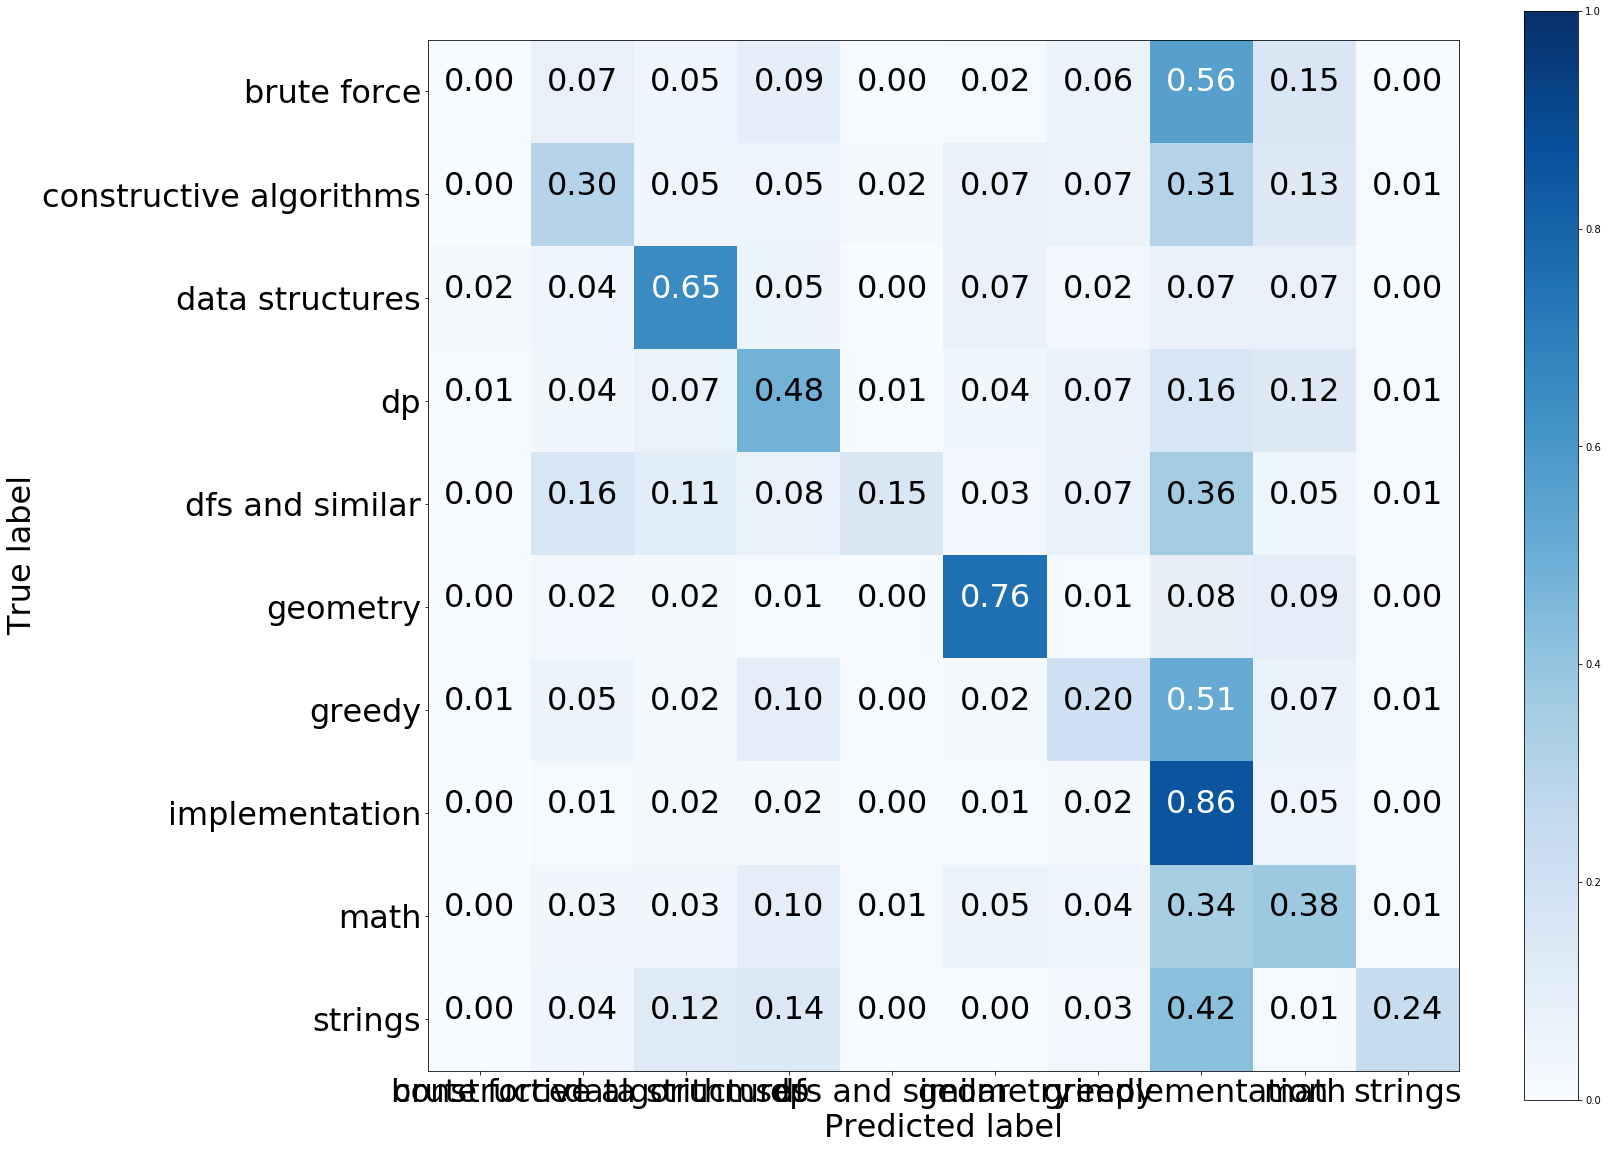

In [14]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
# print(f1_score(all_targs, all_preds, average='micro'))
plot_confusion_matrix(targs_txt, preds_txt, labels)